In [18]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import plotly.express as px
from difflib import SequenceMatcher

In [33]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)

In [2]:
# Morbilidad B2
data = pd.read_csv('data/morbilidad_b2.csv')

data['DATE'] = data['ANHO'].astype(str) +'-'+data_lima['MES'].astype(str) 

data_lima = data[(data['DEPARTAMENTO']=='LIMA')].reset_index(drop=True)
data_lima_m = data_lima[(data_lima['PROVINCIA']=='LIMA')].reset_index(drop=True)
del data

C:\Users\johnk\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
data_lima.head()

,ANHO,MES,UBIGEO,DEPARTAMENTO,PROVINCIA,DISTRITO,SECTOR,CATEGORIA,CO_IPRESS,RAZON_SOC,SEXO,EDAD,DIAGNOSTICO,NU_TOTAL_ATENDIDOS,DATE
0,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,15610,CLÍNICA INTERNACIONAL,2,7,R10.2,10,2018-1
1,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,15610,CLÍNICA INTERNACIONAL,2,7,R10.4,11,2018-1
2,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,15610,CLÍNICA INTERNACIONAL,2,7,R11.X,3,2018-1
3,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,15610,CLÍNICA INTERNACIONAL,2,7,R16.0,1,2018-1
4,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,15610,CLÍNICA INTERNACIONAL,2,7,R42.X,1,2018-1


<ipython-input-40-f5b196f84d71>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation = 45)


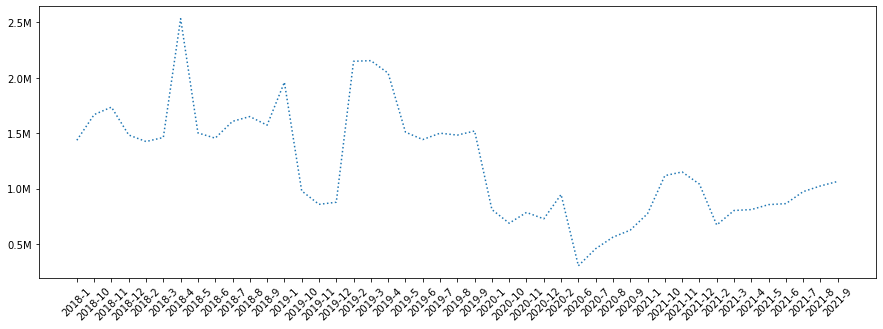

In [40]:
data_temp = data_lima.groupby(['DATE']).agg({ 'NU_TOTAL_ATENDIDOS': "sum"})
data_temp = data_temp.sort_values(by=['DATE']).reset_index()

x = data_temp['DATE']
y = data_temp['NU_TOTAL_ATENDIDOS']

fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)

ax.plot(x, y, linestyle = 'dotted')

ax.yaxis.set_major_formatter(millions)
ax.set_xticklabels(x, rotation = 45)

plt.show()

In [42]:
data_temp = data_lima_m.groupby(['DISTRITO']).agg({ 'NU_TOTAL_ATENDIDOS': "sum"})
data_temp = data_temp.sort_values(by=['DISTRITO']).reset_index()

fig = px.treemap(data_temp, path=[px.Constant('Codigo de distrito'),'DISTRITO'], values='NU_TOTAL_ATENDIDOS',
                  color='NU_TOTAL_ATENDIDOS', hover_data=['DISTRITO'])
fig.show()